In [194]:
import re
import graphviz

40. 係り受け解析結果の読み込み（形態素）

形態素を表すクラスMorphを実装せよ．このクラスは表層形（surface），基本形（base），品詞（pos），品詞細分類1（pos1）をメンバ変数に持つこととする．さらに，係り受け解析の結果（ai.ja.txt.parsed）を読み込み，各文をMorphオブジェクトのリストとして表現し，冒頭の説明文の形態素列を表示せよ．

In [195]:
class Morph:
    
    def __init__(self,surface,base,pos,pos1):
        self.surface = surface
        self.base = base
        self.pos = pos
        self.pos1 = pos1

    def return_parsed(self):
        return [self.surface,self.base,self.pos,self.pos1]

pattern = r'^\* \d+ -?[0-9]+[A-Z] \d+/\d+ -?\d+\.\d+$'

with open('ai.ja.txt.parsed','r') as lines:
    for line in lines:
        matchs = re.findall(pattern,line)
        if line == 'EOS':
            break
        elif matchs:
            match_list = line.split(' ')
            if match_list[1] == '1':
                break
            print(match_list)
        else:
            line = line.split('\t')
            surface,sentences = line[0],line[1]
            sentence = sentences.split(',')
            (base,pos,pos1) = sentence[6],sentence[0],sentence[1]
            m = Morph(surface=surface,base=base,pos=pos,pos1=pos1)
            print(m.return_parsed())

['*', '0', '17D', '3/3', '0.388993\n']
['人工', '人工', '名詞', '一般']
['知能', '知能', '名詞', '一般']
['人工', '人工', '名詞', '一般']
['知能', '知能', '名詞', '一般']


41. 係り受け解析結果の読み込み（文節・係り受け）

40に加えて，文節を表すクラスChunkを実装せよ．このクラスは形態素（Morphオブジェクト）のリスト（morphs），係り先文節インデックス番号（dst），係り元文節インデックス番号のリスト（srcs）をメンバ変数に持つこととする．さらに，入力テキストの係り受け解析結果を読み込み，１文をChunkオブジェクトのリストとして表現し，冒頭の説明文の文節の文字列と係り先を表示せよ．本章の残りの問題では，ここで作ったプログラムを活用せよ．

In [196]:
from typing import Any


class Chunk:
    
    def __init__(self, morphs, dst, srcs, chunk_id):
        self.morphs = morphs
        self.dst = dst
        self.srcs = srcs
        self.chunk_id = chunk_id
        # 43 文節における名詞・動詞の有無フラグ
        self.has_noun = False
        self.has_verb = False
    
    def return_string_dependency(self):
        surface = []
        for morph in self.morphs:
            surface.append(morph.surface)
        return "".join(surface),self.dst,self.chunk_id
    
    def return_string_sources(self):
        return self.srcs,self.chunk_id

pattern = r'^\* \d+ -?[0-9]+[A-Z] \d+/\d+ -?\d+\.\d+$'
morphs = []
chunks = []
dst = None
srcs = []
chunk_id = -1
has_noun = False
has_verb = False

with open('ai.ja.txt.parsed','r') as lines:
    for line in lines:
        matchs = re.findall(pattern,line)
        if line == 'EOS':
            # 最後まで行ったら終了
            c = Chunk(morphs,dst,srcs,chunk_id)
            chunks.append(c)
            if has_noun:
                c.has_noun = True
            elif has_verb:
                c.has_verb = True
            break
        elif matchs:
            match_list = line.split(' ')
            # 一番最初はやらない
            if chunk_id < 0:
                chunk_id = 0
            # 2回目以降
            else:
                c = Chunk(morphs,dst,srcs,chunk_id)
                chunks.append(c)
                if has_noun:
                    c.has_noun = True
                elif has_verb:
                    c.has_verb = True
            morphs = []
            dst = int(match_list[2].replace("D", ""))
            chunk_id = int(match_list[1])
            srcs=[]
            has_noun = False
            has_verb = False
        else:
            line = line.split('\t')
            (surface,sentences) = line[0],line[1]
            sentence = sentences.split(',')
            (base,pos,pos1) = sentence[6],sentence[0],sentence[1]
            # 42 記号削除
            if pos == '記号':
                morphs.append(Morph('',base,pos,pos1))
            else:
                morphs.append(Morph(surface,base,pos,pos1))   
            # 43 文節における名詞・動詞の有無
            if pos == '名詞':
                has_noun = True
            elif pos == '動詞':
                has_verb = True
                     

for chunk in chunks[-5:]:
    (sentence,dst,id) = chunk.return_string_dependency()
    print(f"インデックス番号：{id}\n文節の文字列：{sentence}\n係り先のインデックス番号：{dst}\n")

インデックス番号：2937
文節の文字列：発言し
係り先のインデックス番号：2941

インデックス番号：2938
文節の文字列：伊勢田は
係り先のインデックス番号：2941

インデックス番号：2939
文節の文字列：決着は
係り先のインデックス番号：2940

インデックス番号：2940
文節の文字列：つかないでしょうねと
係り先のインデックス番号：2941

インデックス番号：2941
文節の文字列：答えている
係り先のインデックス番号：-1



42. 係り元と係り先の文節の表示

係り元の文節と係り先の文節のテキストをタブ区切り形式ですべて抽出せよ．ただし，句読点などの記号は出力しないようにせよ．

In [197]:
# srcsにデータ挿入
for chunk in range(len(chunks)):
    (sentence,dst,id) = chunks[chunk].return_string_dependency()
    chunks[dst].srcs.append(id)

# 一部表示
for chunk in range(len(chunks)//300):
    source = []
    (srcs, id) = chunks[chunk].return_string_sources()
    for srcs_index in srcs:
        if srcs_index < 0:
            continue
        (mor, _, _)=chunks[srcs_index].return_string_dependency()
        source.append(mor)
    (main, dst, _)=chunks[chunk].return_string_dependency()
    dst_mor = None
    if dst > 0:
        (dst_mor, _, _)=chunks[dst].return_string_dependency()
    print(f"{source}\t{dst_mor}")

[]	語
[]	語
[]	エーアイとは
['AI']	語
[]	という
['計算']	道具を
[]	道具を
[]	という
['コンピュータ']	道具を


43. 名詞を含む文節が動詞を含む文節に係るものを抽出

名詞を含む文節が，動詞を含む文節に係るとき，これらをタブ区切り形式で抽出せよ．ただし，句読点などの記号は出力しないようにせよ．

In [198]:
for chunk in range(len(chunks)//50):
    (mor_n, dst, _) = chunks[chunk].return_string_dependency()
    (mor_v, _, _) = chunks[dst].return_string_dependency()
    if dst > 0 and chunks[chunk].has_noun and chunks[dst].has_verb:
        print(f"{mor_n}\t{mor_v}")

道具を	用いて
一分野を	指す
知的行動を	代わって
人間に	代わって
コンピューターに	行わせる
研究分野とも	される
解説で	述べている
佐藤理史は	述べている
次のように	述べている
技術ソフトウェアコンピュータシステム	ある
応用例は	ある


44. 係り受け木の可視化

与えられた文の係り受け木を有向グラフとして可視化せよ．可視化には，[Graphviz](http://www.graphviz.org/)等を用いるとよい．
(今回用いたインターフェースは[これ](https://graphviz.readthedocs.io/en/stable/manual.html))

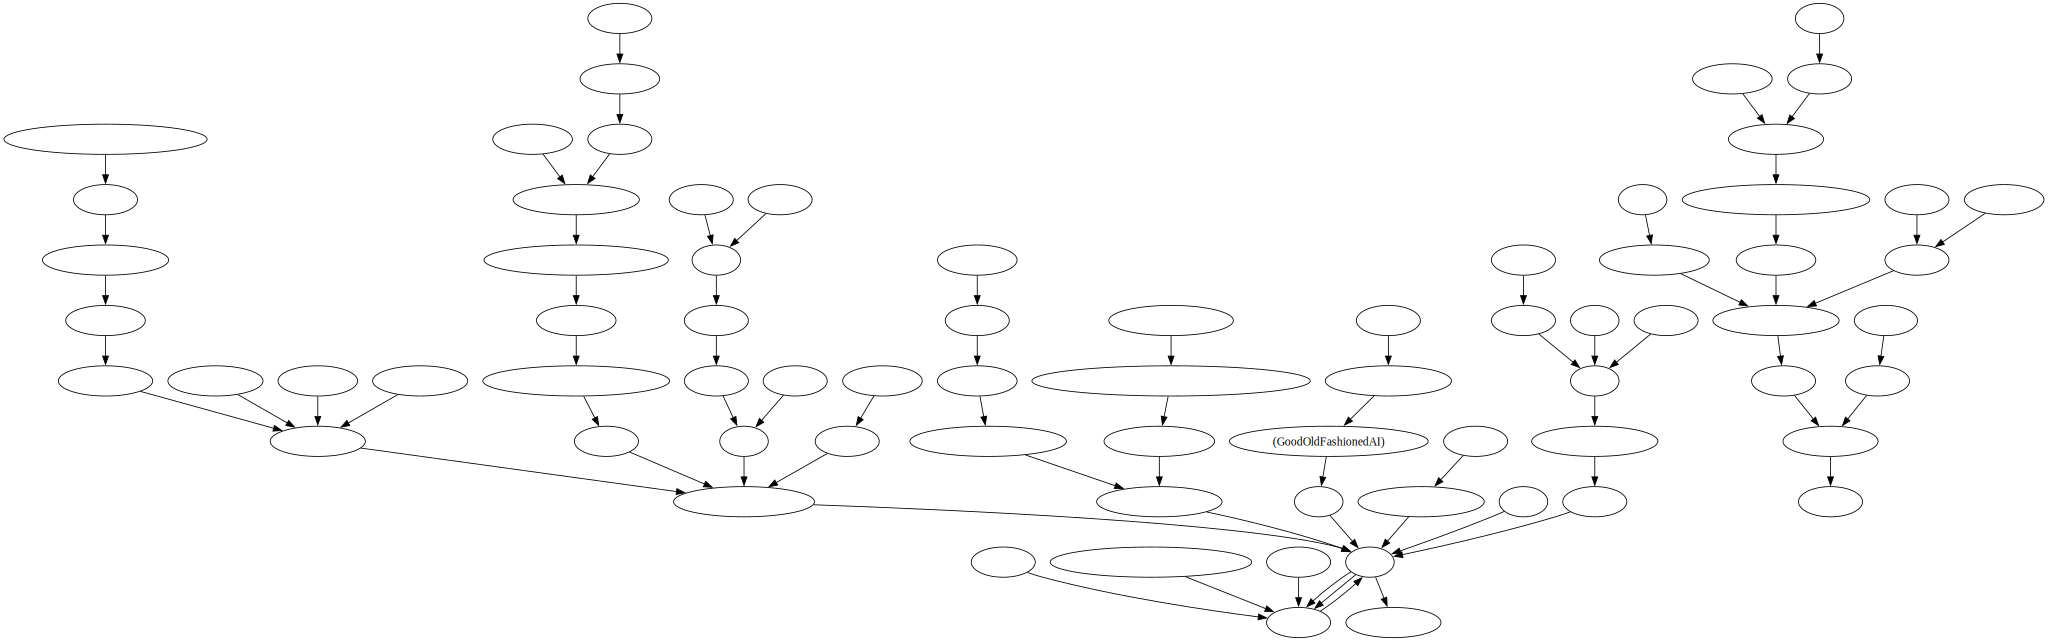

In [199]:
# これだと枝が重複するかも
# 固有IDあった方が良い
branchs = []
d = graphviz.Digraph()
for chunk in range(85,158): # 5行目の文章
    (tail, dst, _) = chunks[chunk].return_string_dependency()
    (head, _, _) = chunks[dst].return_string_dependency()
    if dst > 0:
        d.edge(tail,head)
d

45. 動詞の格パターンの抽出

今回用いている文章をコーパスと見なし，日本語の述語が取りうる格を調査したい． 動詞を述語，動詞に係っている文節の助詞を格と考え，述語と格をタブ区切り形式で出力せよ． ただし，出力は以下の仕様を満たすようにせよ．

- 動詞を含む文節において，最左の動詞の基本形を述語とする
- 述語に係る助詞を格とする
- 述語に係る助詞（文節）が複数あるときは，すべての助詞をスペース区切りで辞書順に並べる

「ジョン・マッカーシーはAIに関する最初の会議で人工知能という用語を作り出した。」という例文を考える． この文は「作り出す」という１つの動詞を含み，「作り出す」に係る文節は「ジョン・マッカーシーは」，「会議で」，「用語を」であると解析された場合は，次のような出力になるはずである．

```zsh
作り出す	で は を
```

このプログラムの出力をファイルに保存し，以下の事項をUNIXコマンドを用いて確認せよ．

- コーパス中で頻出する述語と格パターンの組み合わせ
- 「行う」「なる」「与える」という動詞の格パターン（コーパス中で出現頻度の高い順に並べよ）


In [200]:
f = open('verb_kaku.txt','w')
# 動詞に助詞がかかる場合のみ取り出す
for chunk in range(len(chunks)):
    if chunks[chunk].has_verb:
        verb = None
        morphs = chunks[chunk].morphs
        for morph in morphs:
            (_, base, pos, _) = morph.return_parsed()
            if pos == '動詞':
                verb = base
        kakus = []
        (srcs, id) = chunks[chunk].return_string_sources()
        for srcs_index in srcs:
            if srcs_index < 0:
                continue
            kaku = ''
            morphs=chunks[srcs_index].morphs
            for morph in morphs:
                (_, base, pos, _) = morph.return_parsed()
                if pos == '助詞':
                    kaku = base
            kakus.append(kaku)
        # print(verb+'\t',*kakus,sep=' ')
        f.write(verb+'\t'+' '.join(sorted(kakus))+'\n')
f.close()

- コーパス中で頻出する述語と格パターンの組み合わせ

```zsh

% sort verb_kaku.txt | uniq -c | sort -n -r | head
  11 よる       に
   7 れる       と
   6 する       と
   5 用いる     を
   5 基づく     に
   4 行う       を
   4 ある       が
   3 関わる     も
   3 向ける     に
   3 受ける     を

```

- 「行う」「なる」「与える」という動詞の格パターン（コーパス中で出現頻度の高い順に並べよ）

```zsh

% grep "^行う\t" verb_kaku.txt | sort | uniq -c | sort -n -r | head
   4 行う       を
   1 行う       に を を
   1 行う       で に を
   1 行う        は を
   1 行う        で を

% grep "^なる\t" verb_kaku.txt | sort | uniq -c | sort -n -r | head
   2 なる       が と
   1 なる       が にとって は
   1 なる       と など
   1 なる       が て と
   1 なる       は を
   1 なる       に は
   1 なる       が に
   1 なる       に
   1 なる       と
   1 なる        が で と に は は

% grep "^与える\t" verb_kaku.txt | sort | uniq -c | sort -n -r | head
   1 与える     に は を
   1 与える     が に

```


46. 動詞の格フレーム情報の抽出

45のプログラムを改変し，述語と格パターンに続けて項（述語に係っている文節そのもの）をタブ区切り形式で出力せよ．45の仕様に加えて，以下の仕様を満たすようにせよ．

- 項は述語に係っている文節の単語列とする（末尾の助詞を取り除く必要はない）
- 述語に係る文節が複数あるときは，助詞と同一の基準・順序でスペース区切りで並べる

「ジョン・マッカーシーはAIに関する最初の会議で人工知能という用語を作り出した。」という例文を考える． この文は「作り出す」という１つの動詞を含み，「作り出す」に係る文節は「ジョン・マッカーシーは」，「会議で」，「用語を」であると解析された場合は，次のような出力になるはずである．

```zsh
作り出す	で は を	会議で ジョンマッカーシーは 用語を
```

In [201]:
f = open('verb_kaku_kou.txt','w')
# 項を追加
for chunk in range(len(chunks)):
    if chunks[chunk].has_verb:
        verb = None
        morphs = chunks[chunk].morphs
        for morph in morphs:
            (_, base, pos, _) = morph.return_parsed()
            if pos == '動詞':
                verb = base
        kakus, kous = [], []
        (srcs, id) = chunks[chunk].return_string_sources()
        for srcs_index in srcs:
            if srcs_index < 0:
                continue
            kaku, kou = '', ''
            morphs = chunks[srcs_index].morphs
            (mor, _, _) = chunks[srcs_index].return_string_dependency()
            for morph in morphs:
                (_, base, pos, _) = morph.return_parsed()
                if pos == '助詞':
                    kaku = base
                    kou = mor
            kakus.append([kaku, kou])
        kakus = sorted(kakus, key=lambda x: x[0])
        f.write(verb+'\t'+' '.join([x[0] for x in kakus])+'\t'+' '.join([x[1] for x in kakus])+'\n')
f.close()

- 出力結果における先頭10行

```txt
用いる	を	道具を
指す	を	一分野を
代わる	に を	人間に 知的行動を
せる	て に	代わって コンピューターに
れる	も	研究分野とも
いる	で に は	解説で 次のように 佐藤理史は
ある	 が は	 画像認識等が 応用例は
用いる	を	記号処理を
する	と を	主体と 記述を
いる	 でも は	 意味あいでも 現在では
```